In [1]:
# Author Dmitry Ermilov
import numpy as np
import matplotlib.pyplot as plt
import imageio
import re
from skimage import color

'''
Load a PFM file into a Numpy array. Note that it will have
a shape of H x W, not W x H. Returns a tuple containing the
loaded image and the scale factor from the file.
'''
def load_pfm(file):
    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().decode('utf-8').rstrip()
    if header == 'PF':
        color = True    
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode('utf-8').rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)
    return np.reshape(data, shape), scale

def compress(image, k=2):
    n, m = image.shape[:2]
    n_k = n // k
    m_k = m // k
    new_image = np.zeros_like(image)[:n_k, :m_k]
    for i in range(n_k):
        for j in range(m_k):
            new_image[i, j] = np.mean(image[k*i:k*(i+1), k*j:k*(j+1)].reshape(k**2, -1), axis=0)
    return new_image

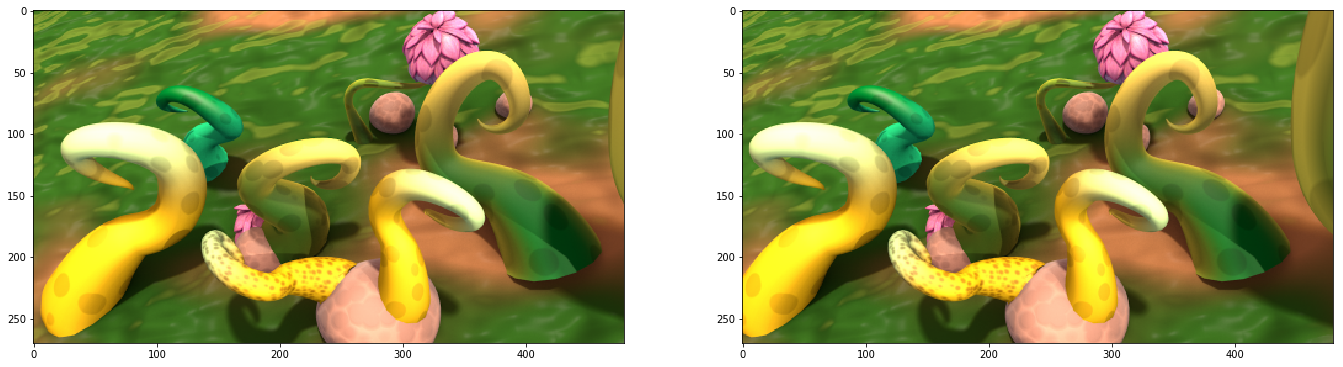

In [2]:
with open("0134l.pfm", "rb") as f:
    disp_l = compress(load_pfm(f)[0][::-1]) / 2
with open("0134r.pfm", "rb") as f:
    disp_r = compress(load_pfm(f)[0][::-1]) / 2
    
imgL = compress(imageio.imread("0134l.png"))
imgR = compress(imageio.imread("0134r.png"))

plt.figure(figsize=(36, 12))
plt.subplot(131)
plt.imshow(imgL)
plt.subplot(132)
plt.imshow(imgR)

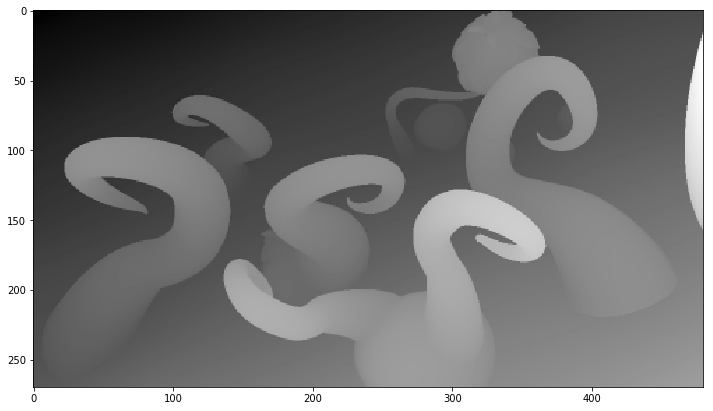

In [3]:
plt.figure(figsize=(12, 8))
plt.imshow(disp_l, cmap="gray")

In [4]:
indices_rl = np.int32(-100) * np.ones(imgL.shape[:2], dtype=np.int32)
for r, row in enumerate(np.int32(disp_r)):
    for v, val in enumerate(row):
        indices_rl[r, v] = v + val

newL = np.zeros_like(imgL)
count = 0
for r, row in enumerate(indices_rl):
    for v, val in enumerate(row):
        if val < 480 and np.all(newL[r, val] == 0):
            newL[r, val] = imgR[r, v]
        else:
            indices_rl[r, v] = np.int32(-1)

In [5]:
for r in range(indices_rl.shape[0]):
    for v in range(indices_rl.shape[1]-1, -1, -1):
        if np.all(indices_rl[r, v:v+2] == np.int32(-100)):
            indices_rl[r, v:v+4] = np.int32(-100)                  

newL = np.zeros_like(imgL)
for r, row in enumerate(indices_rl):
    for v, val in enumerate(row):
        if val >= 0:
            newL[r, val] = imgR[r, v]

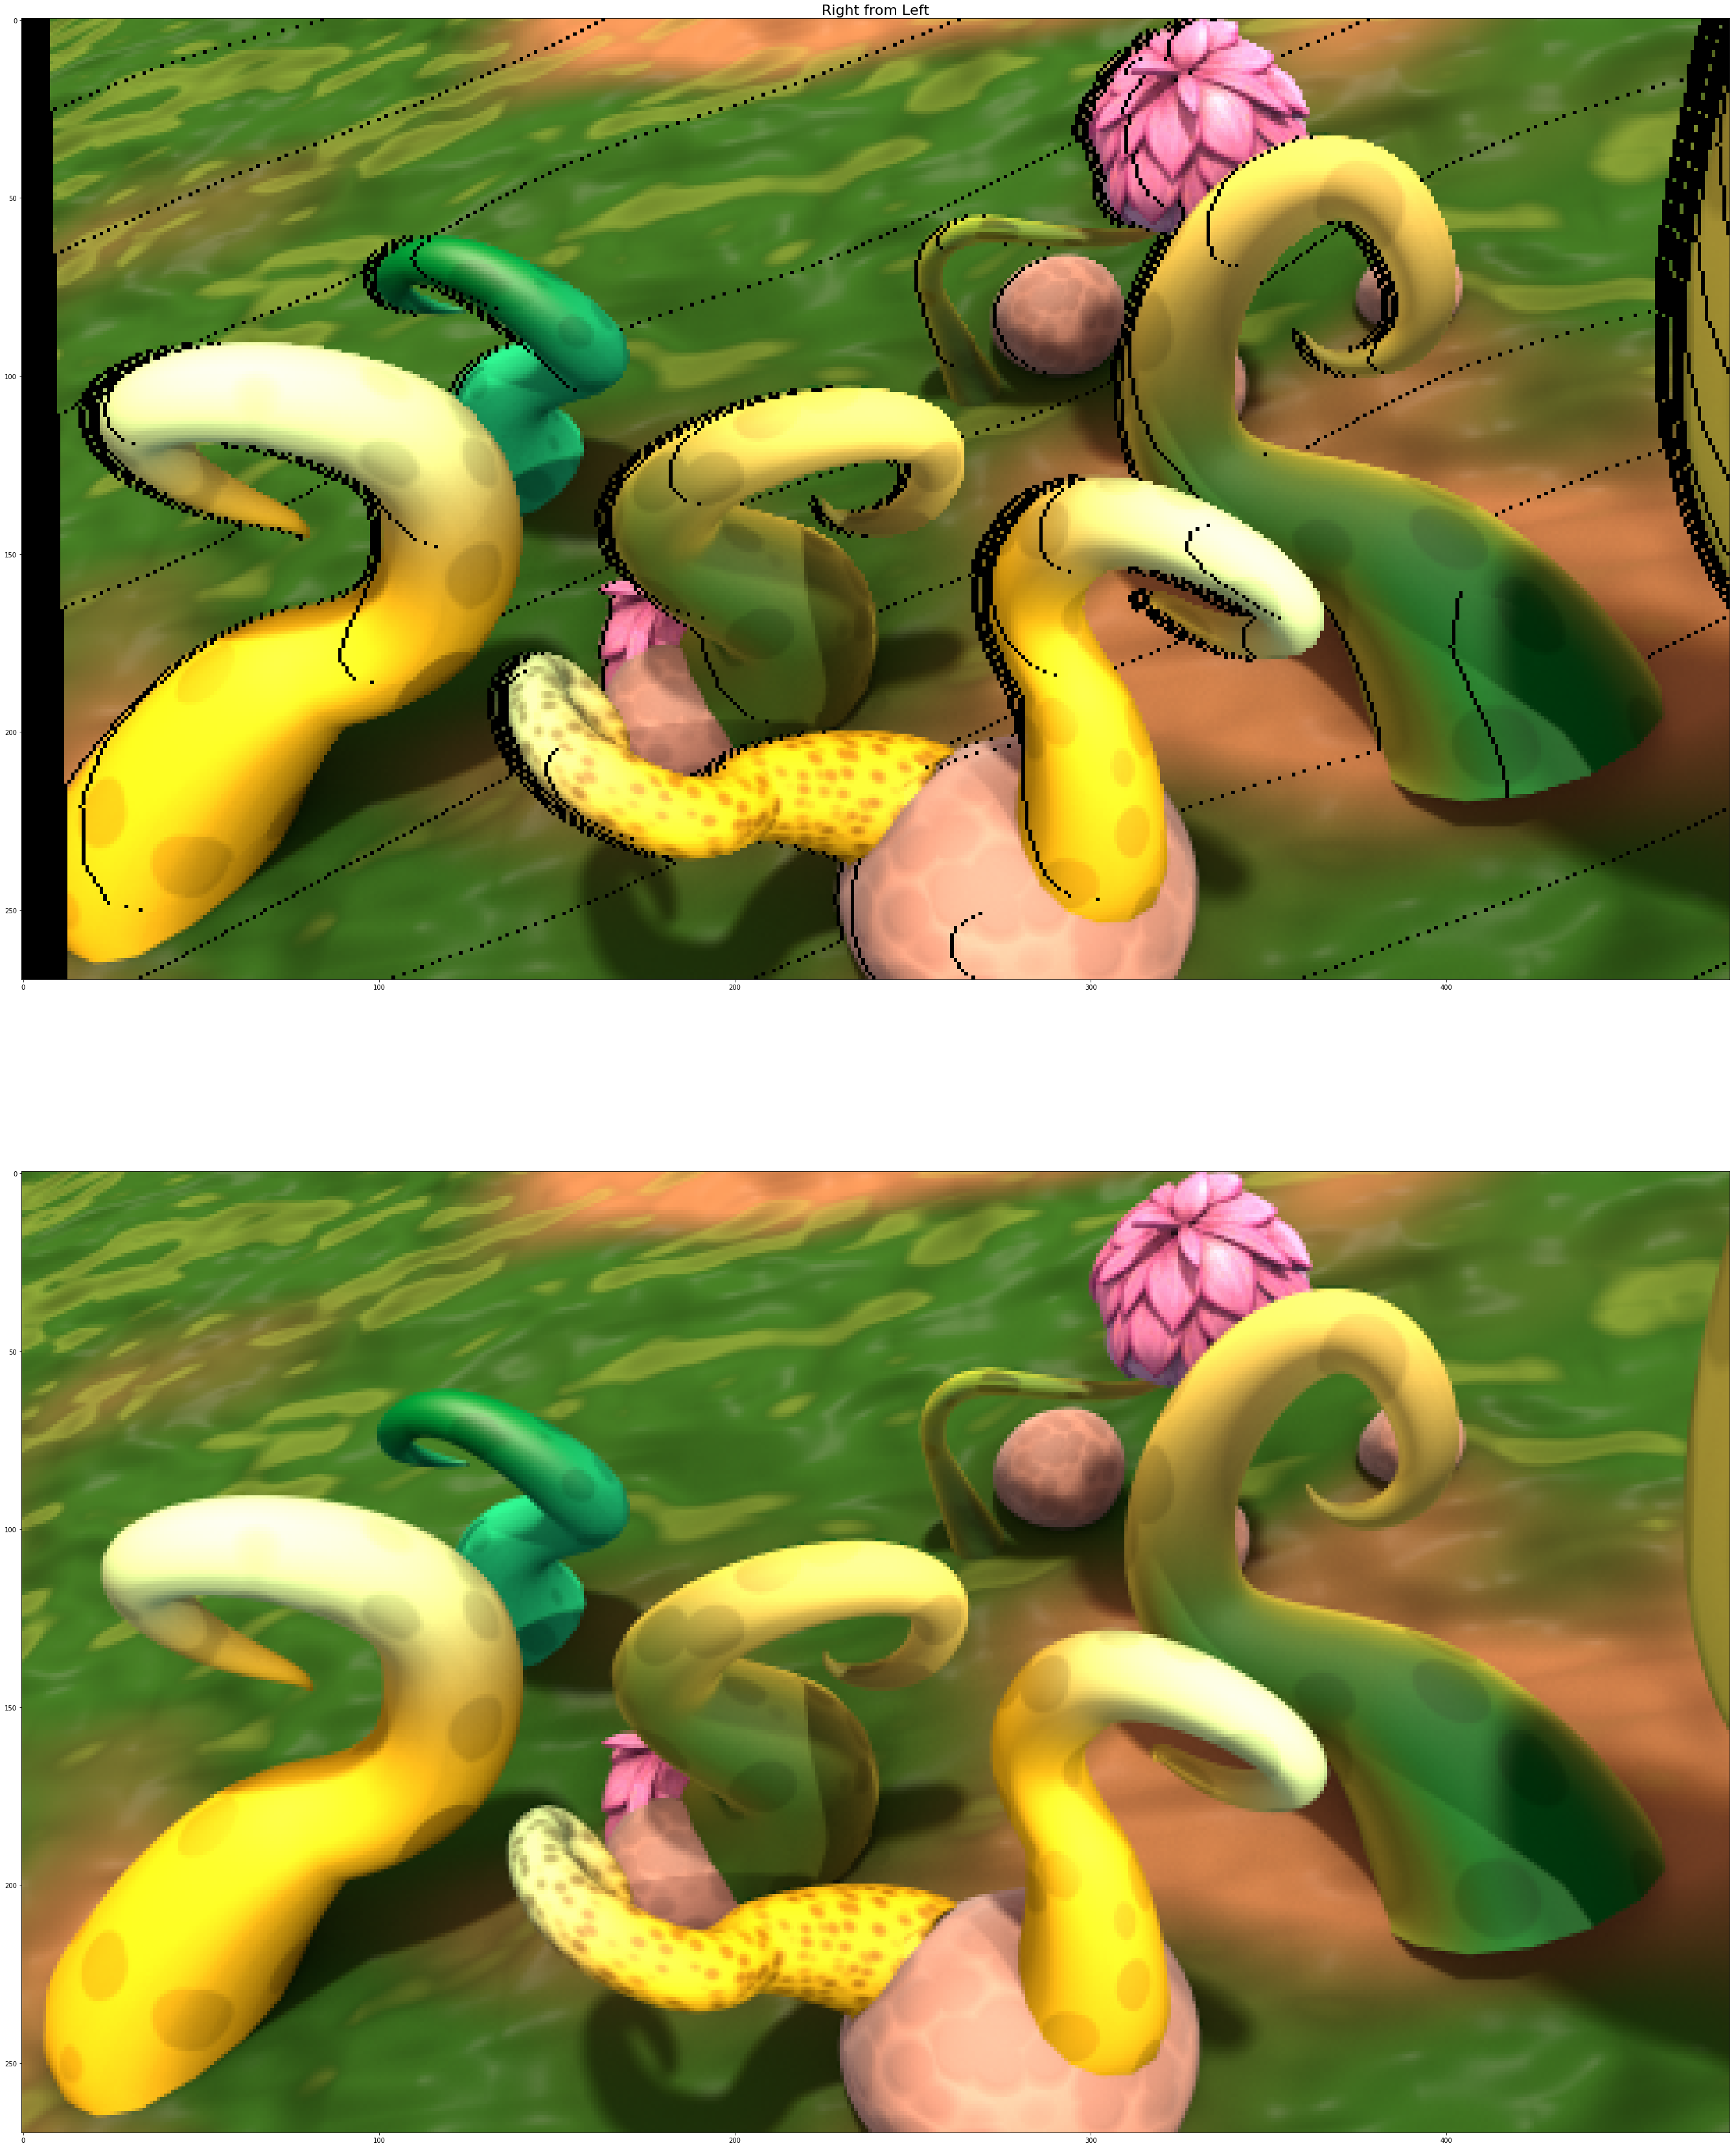

In [6]:
plt.figure(figsize=(50, 60))
plt.subplot(211)
plt.title("Right from Left", fontsize=22)
plt.imshow(newL, alpha=1)
plt.subplot(212)
plt.imshow(imgL)

In [7]:
np.sum((newL - imgL)*(newL > 0)) / np.sum(newL > 0)

73.31715462295371

In [8]:
np.save("tentacle_indices_rl", indices_rl)
plt.imsave("tentacle_l.jpg", imgL, format="jpg")
plt.imsave("tentacle_r.jpg", imgR, format="jpg")

0


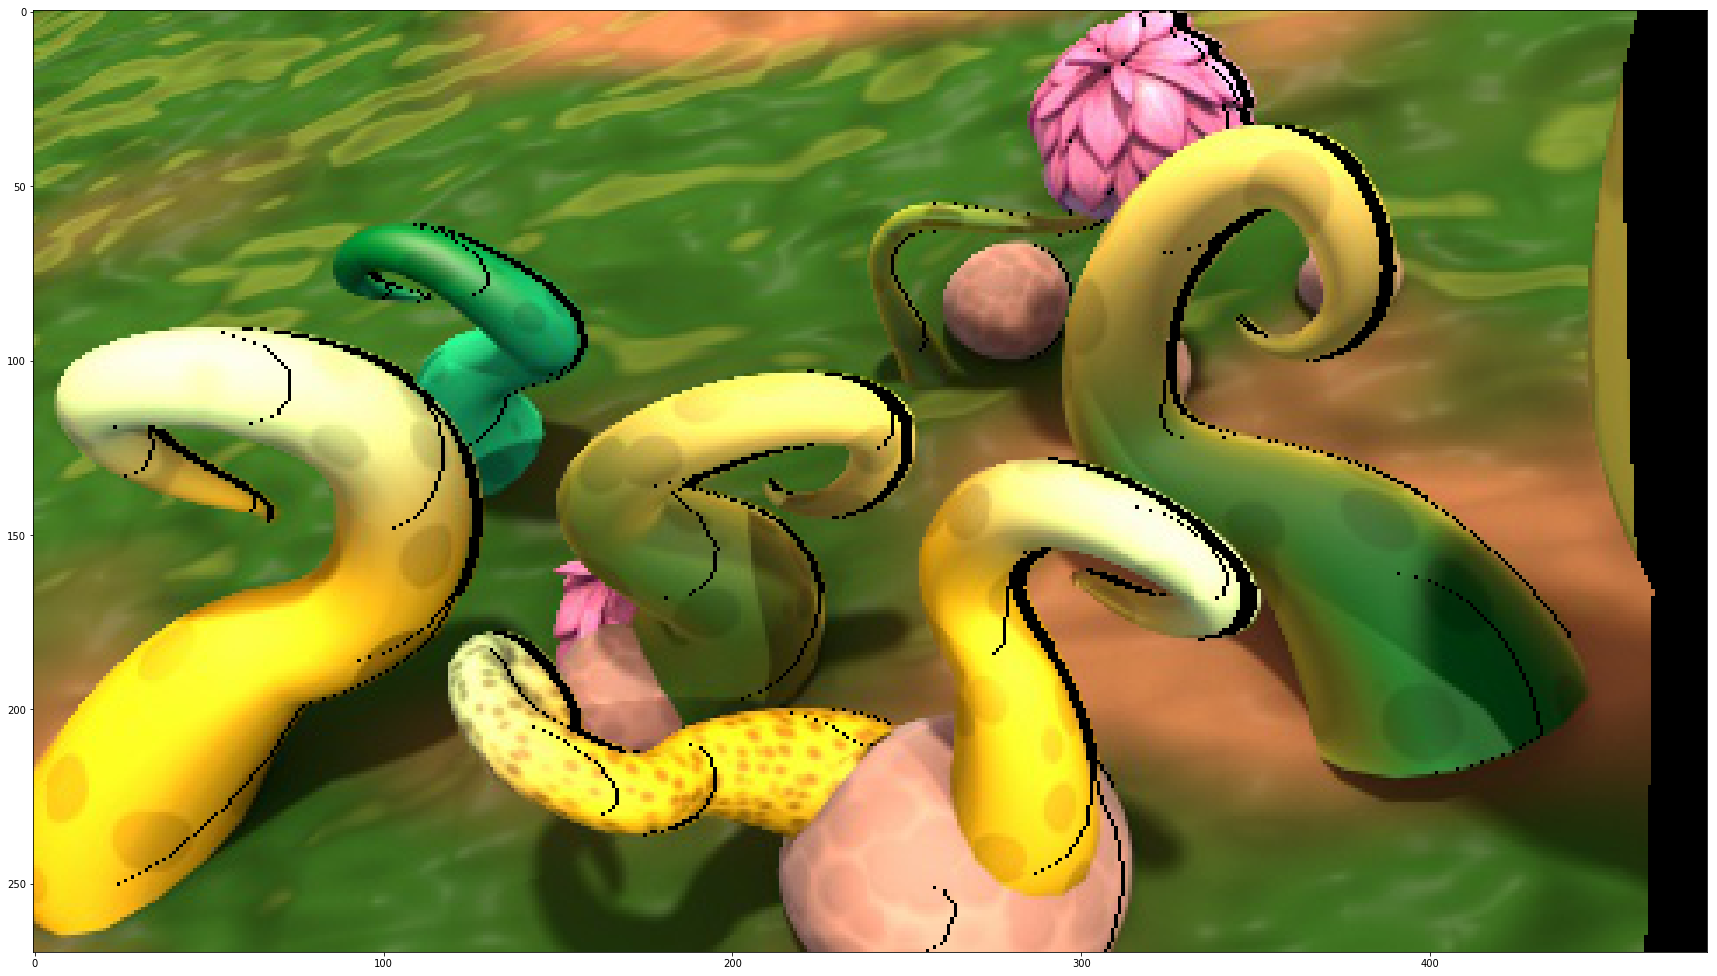

In [9]:
# Reconstruction
imgL = imageio.imread("tentacle_l.jpg")
imgR = imageio.imread("tentacle_r.jpg")
indices = np.load("tentacle_indices_rl.npy")
count = 0
newR = np.zeros_like(imgR)
for r, row in enumerate(indices):
    for v, val in enumerate(row):
        if val >= 0:
            newR[r, v] = imgL[r, val]

print(count)            
plt.figure(figsize=(30, 20))
plt.imshow(newR)

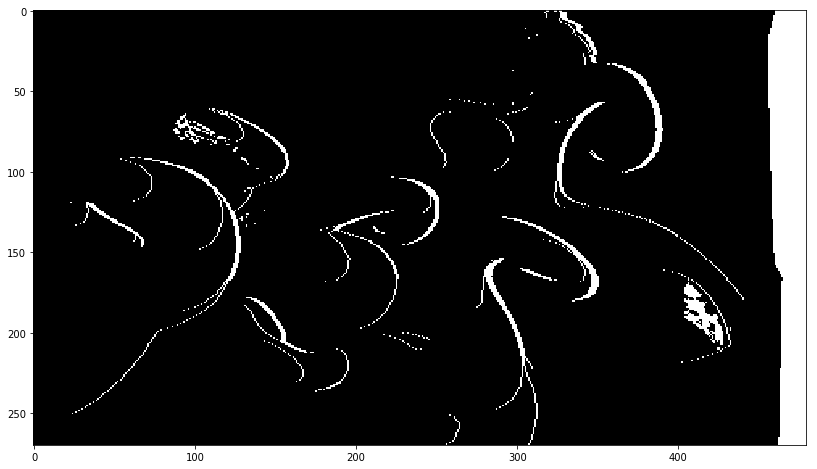

In [10]:
# Mask
plt.figure(figsize=(20, 8))
plt.imshow(newR[:, :, 0] == 0, cmap="gray")

In [11]:
np.sum((color.rgb2hsv(newR) - color.rgb2hsv(imgR))*(newR > 0)) / np.sum(newR > 0)

/home/gyro/cloud/anaconda/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/home/gyro/cloud/anaconda/lib/python3.6/site-packages/skimage/color/colorconv.py:274: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/gyro/cloud/anaconda/lib/python3.6/site-packages/skimage/color/colorconv.py:278: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/gyro/cloud/anaconda/lib/python3.6/site-packages/skimage/color/colorconv.py:282: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


0.0001578713773632497